In [380]:
import pandas as pd
import numpy as np
import csv
from tqdm import tqdm, trange

csv_file = "https://raw.githubusercontent.com/JuntingYu1996/BERT/master/ner_dataset.csv"
encoding = "latin1"
sep = ","
# quoting = csv.QUOTE_NONE
quoting = 0

data = pd.read_csv(csv_file,sep=sep,encoding=encoding,quoting=quoting).fillna(method="ffill")
data.tail(10)

,Sentence #,Word,POS,Tag
1048565,Sentence: 47958,impact,NN,O
1048566,Sentence: 47958,.,.,O
1048567,Sentence: 47959,Indian,JJ,B-gpe
1048568,Sentence: 47959,forces,NNS,O
1048569,Sentence: 47959,said,VBD,O
1048570,Sentence: 47959,they,PRP,O
1048571,Sentence: 47959,responded,VBD,O
1048572,Sentence: 47959,to,TO,O
1048573,Sentence: 47959,the,DT,O
1048574,Sentence: 47959,attack,NN,O


In [381]:
class SentenceGetter(object):
    
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["Word"].values.tolist(),
                                                           s["POS"].values.tolist(),
                                                           s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

In [382]:
getter = SentenceGetter(data)

In [383]:
sentences = [" ".join([s[0] for s in sent]) for sent in getter.sentences]
sentences[0]

'Thousands of demonstrators have marched through London to protest the war in Iraq and demand the withdrawal of British troops from that country .'

In [384]:
import torch
from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pytorch_pretrained_bert import BertTokenizer, BertConfig
from pytorch_pretrained_bert import BertForTokenClassification, BertAdam

In [385]:
MAX_LEN = 75 # maximum number of tokens in a sequence
bs = 32 # batch size
BERT_MAX_LEN = 512

In [386]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()

In [387]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [390]:
# tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]
tokenized_texts = []
labels = [[s[2] for s in sent] for sent in getter.sentences]
for sent in range(len(sentences)):
    tokenized_texts.append([])
    splitted = sentences[sent].split()
    for word in range(len(splitted)):
        for padding in range(len(tokenizer.tokenize(splitted[word])) - 1):
            labels[sent].insert(len(tokenized_texts[-1])+padding+1,'X')
        tokenized_texts[-1].extend(tokenizer.tokenize(splitted[word]))

In [407]:
checking = np.random.randint(len(tokenized_texts))
print("Checking sentence %d"%checking)
print(sentences[checking],"\n")
print(tokenized_texts[checking],'\n')
print("Length of tokenized text: %d\n"%len(tokenized_texts[checking]))
print(labels[checking],'\n')
print("Length of labels: %d\n"%len(labels[checking]))
for token in range(len(tokenized_texts[checking])):
    if labels[checking][token]!='O':
      print(tokenized_texts[checking][token]+" : "+labels[checking][token])

Checking sentence 10226
Lieutenant Nathan Perry Monday told VOA that U.S. helicopters did not enter 

['lieutenant', 'nathan', 'perry', 'monday', 'told', 'vo', '##a', 'that', 'u', '.', 's', '.', 'helicopters', 'did', 'not', 'enter'] 

Length of tokenized text: 16

['O', 'B-per', 'I-per', 'B-tim', 'O', 'B-org', 'X', 'O', 'B-geo', 'X', 'X', 'X', 'O', 'O', 'O', 'O'] 

Length of labels: 16

nathan : B-per
perry : I-per
monday : B-tim
vo : B-org
##a : X
u : B-geo
. : X
s : X
. : X


In [397]:
tags_vals = list(set(data["Tag"].values))
tags_vals.append('X')
tag2idx = {t: i for i, t in enumerate(tags_vals)}
print(tag2idx)
idx2tag = {tag2idx[t]: t for t in tag2idx.keys()}
print(idx2tag)

{'I-art': 0, 'B-art': 1, 'I-per': 2, 'B-eve': 3, 'B-tim': 4, 'I-gpe': 5, 'B-org': 6, 'I-tim': 7, 'I-org': 8, 'I-eve': 9, 'O': 10, 'B-per': 11, 'B-geo': 12, 'B-gpe': 13, 'B-nat': 14, 'I-geo': 15, 'I-nat': 16, 'X': 17}
{0: 'I-art', 1: 'B-art', 2: 'I-per', 3: 'B-eve', 4: 'B-tim', 5: 'I-gpe', 6: 'B-org', 7: 'I-tim', 8: 'I-org', 9: 'I-eve', 10: 'O', 11: 'B-per', 12: 'B-geo', 13: 'B-gpe', 14: 'B-nat', 15: 'I-geo', 16: 'I-nat', 17: 'X'}


In [378]:
sorted(tag2idx)

['B-Amenity',
 'B-Cuisine',
 'B-Dish',
 'B-Hours',
 'B-Location',
 'B-Price',
 'B-Rating',
 'B-Restaurant_Name',
 'I-Amenity',
 'I-Cuisine',
 'I-Dish',
 'I-Hours',
 'I-Location',
 'I-Price',
 'I-Rating',
 'I-Restaurant_Name',
 'O',
 'X']

In [0]:
input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts],
                          maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

In [0]:
tags = pad_sequences([[tag2idx.get(l) for l in lab] for lab in labels],
                     maxlen=MAX_LEN, value=tag2idx["O"], padding="post",
                     dtype="long", truncating="post")

In [0]:
attention_masks = [[float(i>0) for i in ii] for ii in input_ids]

In [0]:
tr_inputs, val_inputs, tr_tags, val_tags = train_test_split(input_ids, tags, random_state=2020, test_size=0.3)
tr_masks, val_masks, _, _ = train_test_split(attention_masks, input_ids, random_state=2020, test_size=0.3)

In [0]:
#random checking

checking = np.random.randint(val_inputs.shape[0])
decoded_tokens = tokenizer.convert_ids_to_tokens(np.array((val_inputs[checking])))
decoded_tokens = [word for word in decoded_tokens if word != '[PAD]']
print(decoded_tokens,"\n")
for word in range(len(decoded_tokens)):
    if val_tags[checking][word]!=tag2idx['O']:
        print("%s: %s "%(decoded_tokens[word],idx2tag[np.int(val_tags[checking][word])]))

['there', 'are', 'precedent', '##s', 'of', 'independent', 'governors', 'dealing', 'effectively', 'with', 'the', 'legislature', ',', 'and', 'indeed', 'a', 'wise', 'third', '-', 'party', 'governor', 'can', 'have', 'greater', 'effectiveness', 'than', 'a', 'major', 'party', 'governor', '.'] 

precedent: B-abstract 
##s: X 
of: I-abstract 
independent: I-abstract 
governors: I-abstract 
the: B-organization 
legislature: I-organization 
a: B-person 
wise: I-person 
third: I-person 
-: X 
party: X 
governor: I-person 
greater: B-abstract 
effectiveness: I-abstract 
a: B-person 
major: I-person 
party: I-person 
governor: I-person 


In [0]:
tr_inputs = torch.tensor(tr_inputs)
val_inputs = torch.tensor(val_inputs)
tr_tags = torch.tensor(tr_tags)
val_tags = torch.tensor(val_tags)
tr_masks = torch.tensor(tr_masks)
val_masks = torch.tensor(val_masks)

In [0]:
train_data = TensorDataset(tr_inputs, tr_masks, tr_tags)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=bs)

valid_data = TensorDataset(val_inputs, val_masks, val_tags)
valid_sampler = SequentialSampler(valid_data)
valid_dataloader = DataLoader(valid_data, sampler=valid_sampler, batch_size=bs)

In [0]:
model = BertForTokenClassification.from_pretrained("bert-base-uncased", num_labels=len(tag2idx))

In [0]:
model.cuda()

BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): BertLayerNorm()
              (dropout): Dropout(p=0.1, inplace=False)
      

In [0]:
FULL_FINETUNING = True
if FULL_FINETUNING:
    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.0}
    ]
else:
    param_optimizer = list(model.classifier.named_parameters()) 
    optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]
optimizer = Adam(optimizer_grouped_parameters, lr=3e-5)

In [0]:
from sklearn.metrics import f1_score, accuracy_score

def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=2).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [0]:
# checking whether loss is equal when active labels contain 'X' or not
# loss_fct = torch.nn.CrossEntropyLoss(ignore_index=tag2idx['X'])
# checking = np.random.randint(tr_inputs.shape[0])
# b_input_ids, b_input_mask, b_labels = tr_inputs[checking:checking+1].to(device),tr_masks[checking:checking+1].to(device),tr_tags[checking:checking+1].to(device)
# decoded_tokens = tokenizer.convert_ids_to_tokens(np.array((tr_inputs[checking])))
# decoded_tokens = [word for word in decoded_tokens if word != '[PAD]']
# print(decoded_tokens,"\n")
# active = ((b_input_mask.view(-1) == 1) * (b_labels.view(-1) != tag2idx['X']))
# logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
# active_logits = logits.view(-1, len(tag2idx))[active]
# active_labels = b_labels.view(-1)[active]
# print(active_labels)
# loss = loss_fct(active_logits, active_labels)
# print(loss.item())


# active = (b_input_mask.view(-1) == 1)
# logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
# active_logits = logits.view(-1, len(tag2idx))[active]
# active_labels = b_labels.view(-1)[active]
# print(active_labels)
# loss = loss_fct(active_logits, active_labels)
# print(loss.item())

In [0]:
weight_fct = lambda num: 1
weight = np.array([weight_fct(np.sum(tags == i)) for i in range(len(tag2idx))],dtype=float)
weight[tag2idx['X']] = 0
weight = torch.tensor(weight).to(torch.float)
print(weight)

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 0.])


In [0]:
from copy import deepcopy

epochs = 50
max_grad_norm = 1.0

loss_fct = torch.nn.CrossEntropyLoss
loss_fct_gpu = loss_fct(weight=weight.to('cuda'),ignore_index=tag2idx['X'])
loss_fct_cpu = loss_fct(weight=weight.to('cpu'),ignore_index=tag2idx['X'])

best_F1 = 0
best_accuracy = 0
best_model = None

train_losses, validation_losses, accuracies, F1s = [],[],[],[]

for _ in trange(epochs, desc="Epoch"):
    # TRAIN loop
    model.train()
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0
    for step, batch in enumerate(train_dataloader):
        # add batch to gpu
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        # forward pass
        
        active = ((b_input_mask.view(-1) == 1) * (b_labels.view(-1) != tag2idx['X']))
        logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
        active_logits = logits.view(-1, len(tag2idx))[active]
        active_labels = b_labels.view(-1)[active]
        loss = loss_fct_gpu(active_logits, active_labels)
        # backward pass
        loss.backward()
        # track train loss
        tr_loss += loss.item()
        nb_tr_examples += b_input_ids.size(0)
        nb_tr_steps += 1
        # gradient clipping
        torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=max_grad_norm)
        # update parameters
        optimizer.step()
        model.zero_grad()
    # print train loss per epoch
    # print("Train loss: {}".format(tr_loss/nb_tr_steps))
    # VALIDATION on validation set
    model.eval()
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    predictions , true_labels = [], []
    for batch in valid_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        
        with torch.no_grad():
            # tmp_eval_loss = model(b_input_ids, token_type_ids=None,
            #                       attention_mask=b_input_mask, labels=b_labels)
            logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

# original
#         logits = logits.detach().cpu().numpy()
#         label_ids = b_labels.to('cpu').numpy()
#         predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
#         true_labels.append(label_ids)
#         tmp_eval_accuracy = flat_accuracy(logits, label_ids)
#         eval_accuracy += tmp_eval_accuracy

#revised
        active = ((b_input_mask.view(-1) == 1) * (b_labels.view(-1) != tag2idx['X']))
        active_logits = logits.view(-1, len(tag2idx))[active].cpu()
        active_labels = b_labels.view(-1)[active].cpu()
        loss = loss_fct_cpu(active_logits, active_labels)
        pred_labels = np.argmax(active_logits, axis=1)
        predictions.append(pred_labels)
        true_labels.append(active_labels)
        
        
        eval_loss += loss.item()
        
        nb_eval_examples += b_input_ids.size(0)
        nb_eval_steps += 1
    eval_loss = eval_loss/nb_eval_steps
    tr_loss = tr_loss/nb_eval_steps
    predictions = np.concatenate(predictions)
    true_labels = np.concatenate(true_labels)
    eval_accuracy = accuracy_score(true_labels, predictions, normalize=True, sample_weight=None)
    F1 = f1_score(true_labels, predictions, average='macro')
    print("Train loss: {}".format(tr_loss))
    print("Validation loss: {}".format(eval_loss))
    print("Validation Accuracy: {}".format(eval_accuracy))
    print("F1-Score: {}".format(F1))
    train_losses.append(tr_loss)
    validation_losses.append(eval_loss)
    accuracies.append(eval_accuracy)
    F1s.append(F1)

    if F1 > best_F1:
        best_F1, best_accuracy, best_model = F1, eval_accuracy, deepcopy(model)


Epoch:   0%|          | 0/50 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)

Epoch:   2%|▏         | 1/50 [00:29<23:56, 29.32s/it]

Train loss: 4.214677738420891
Validation loss: 1.2712256095626138
Validation Accuracy: 0.633559598153679
F1-Score: 0.21851146695874962



Epoch:   4%|▍         | 2/50 [00:58<23:27, 29.33s/it]

Train loss: 2.5252207680182024
Validation loss: 0.9748769059325709
Validation Accuracy: 0.7186532717893022
F1-Score: 0.4580010899097184



Epoch:   6%|▌         | 3/50 [01:27<22:55, 29.26s/it]

Train loss: 1.8397673693570225
Validation loss: 0.9261372053261959
Validation Accuracy: 0.7323377681238121
F1-Score: 0.5428055428820568



Epoch:   8%|▊         | 4/50 [01:57<22:26, 29.27s/it]

Train loss: 1.3914752250367945
Validation loss: 0.9271842241287231
Validation Accuracy: 0.7376595166983437
F1-Score: 0.6057812307697468



Epoch:  10%|█         | 5/50 [02:26<21:58, 29.29s/it]

Train loss: 1.0175983147187666
Validation loss: 1.0059846784129287
Validation Accuracy: 0.7426011403746945
F1-Score: 0.6189257653654494



Epoch:  12%|█▏        | 6/50 [02:55<21:26, 29.24s/it]

Train loss: 0.7294880467833895
Validation loss: 1.0462872115048496
Validation Accuracy: 0.7490632636437686
F1-Score: 0.6255317366938133



Epoch:  14%|█▍        | 7/50 [03:24<20:57, 29.24s/it]

Train loss: 0.548250515352596
Validation loss: 1.133968629620292
Validation Accuracy: 0.7480314960629921
F1-Score: 0.6183430600262756



Epoch:  16%|█▌        | 8/50 [03:53<20:26, 29.20s/it]

Train loss: 0.4094369499520822
Validation loss: 1.1946092356335034
Validation Accuracy: 0.7451534075481944
F1-Score: 0.6186411387752279



Epoch:  18%|█▊        | 9/50 [04:23<19:58, 29.23s/it]

Train loss: 0.33395394095868774
Validation loss: 1.2183843887213506
Validation Accuracy: 0.7525386912842791
F1-Score: 0.628201945292912



Epoch:  20%|██        | 10/50 [04:52<19:27, 29.19s/it]

Train loss: 0.27079844147418486
Validation loss: 1.2506187774918296
Validation Accuracy: 0.7554167797990768
F1-Score: 0.6274304247006782



Epoch:  22%|██▏       | 11/50 [05:21<18:59, 29.22s/it]

Train loss: 0.21697807029792757
Validation loss: 1.303796730258248
Validation Accuracy: 0.7559055118110236
F1-Score: 0.6301563179521796



Epoch:  24%|██▍       | 12/50 [05:50<18:29, 29.20s/it]

Train loss: 0.1838014739932436
Validation loss: 1.3401407780069294
Validation Accuracy: 0.7583491718707576
F1-Score: 0.6355843334287724



Epoch:  26%|██▌       | 13/50 [06:19<18:00, 29.20s/it]

Train loss: 0.1474974968216636
Validation loss: 1.424536574970592
Validation Accuracy: 0.7534618517512897
F1-Score: 0.6361761530526412



Epoch:  28%|██▊       | 14/50 [06:49<17:30, 29.18s/it]

Train loss: 0.1201435373813817
Validation loss: 1.4316744190273862
Validation Accuracy: 0.7575889220743959
F1-Score: 0.6469978559934432



Epoch:  30%|███       | 15/50 [07:18<17:01, 29.20s/it]

Train loss: 0.10154087514136777
Validation loss: 1.4834134398084697
Validation Accuracy: 0.759706760792832
F1-Score: 0.6409606881675878



Epoch:  32%|███▏      | 16/50 [07:47<16:32, 29.18s/it]

Train loss: 0.09026920736174691
Validation loss: 1.527702889659188
Validation Accuracy: 0.7560684224816725
F1-Score: 0.6322445296973884



Epoch:  34%|███▍      | 17/50 [08:16<16:03, 29.20s/it]

Train loss: 0.07608035212439118
Validation loss: 1.5618869481664714
Validation Accuracy: 0.7559055118110236
F1-Score: 0.6396056236418036



Epoch:  36%|███▌      | 18/50 [08:45<15:32, 29.15s/it]

Train loss: 0.07482431560867664
Validation loss: 1.5792023485357112
Validation Accuracy: 0.7561770295954385
F1-Score: 0.645041040276935



Epoch:  38%|███▊      | 19/50 [09:15<15:05, 29.20s/it]

Train loss: 0.06408327511709297
Validation loss: 1.5735714182709202
Validation Accuracy: 0.7606842248167255
F1-Score: 0.6431707008467518



Epoch:  40%|████      | 20/50 [09:44<14:34, 29.16s/it]

Train loss: 0.06340948510632823
Validation loss: 1.5725411555983804
Validation Accuracy: 0.7599239750203638
F1-Score: 0.6369594088098733



Epoch:  42%|████▏     | 21/50 [10:13<14:06, 29.20s/it]

Train loss: 0.05548128426413645
Validation loss: 1.6208384651126284
Validation Accuracy: 0.759652457235949
F1-Score: 0.6368806979535654



Epoch:  44%|████▍     | 22/50 [10:42<13:36, 29.15s/it]

Train loss: 0.056276644043850174
Validation loss: 1.6135595151872346
Validation Accuracy: 0.7569372793918001
F1-Score: 0.642670653649202



Epoch:  46%|████▌     | 23/50 [11:11<13:06, 29.11s/it]

Train loss: 0.045312836872075095
Validation loss: 1.7170467268336902
Validation Accuracy: 0.7442302470811838
F1-Score: 0.6272931520941282



Epoch:  48%|████▊     | 24/50 [11:40<12:36, 29.09s/it]

Train loss: 0.043436562614233204
Validation loss: 1.6815656008142414
Validation Accuracy: 0.7590551181102362
F1-Score: 0.6367133200545341



Epoch:  50%|█████     | 25/50 [12:09<12:06, 29.06s/it]

Train loss: 0.03373165805400773
Validation loss: 1.7004632046728423
Validation Accuracy: 0.7478142818354602
F1-Score: 0.6263816598251767



Epoch:  52%|█████▏    | 26/50 [12:38<11:37, 29.06s/it]

Train loss: 0.039675421377813276
Validation loss: 1.7383535251472935
Validation Accuracy: 0.7625305457507466
F1-Score: 0.6418281096474093



Epoch:  54%|█████▍    | 27/50 [13:07<11:09, 29.11s/it]

Train loss: 0.032219782415213005
Validation loss: 1.734335933670853
Validation Accuracy: 0.7603040999185446
F1-Score: 0.6388584018818169



Epoch:  56%|█████▌    | 28/50 [13:36<10:40, 29.10s/it]

Train loss: 0.028494198093981002
Validation loss: 1.7503589789072673
Validation Accuracy: 0.7581319576432256
F1-Score: 0.6425671011569263



Epoch:  58%|█████▊    | 29/50 [14:05<10:10, 29.07s/it]

Train loss: 0.030515191268712057
Validation loss: 1.7728898254307834
Validation Accuracy: 0.7619332066250339
F1-Score: 0.6468461934620983



Epoch:  60%|██████    | 30/50 [14:34<09:41, 29.06s/it]

Train loss: 0.02531300427984785
Validation loss: 1.7537455757459004
Validation Accuracy: 0.7621504208525658
F1-Score: 0.6445000579493315



Epoch:  62%|██████▏   | 31/50 [15:03<09:12, 29.05s/it]

Train loss: 0.025362633847786736
Validation loss: 1.7951875563823816
Validation Accuracy: 0.7581319576432256
F1-Score: 0.6381979360205333



Epoch:  64%|██████▍   | 32/50 [15:32<08:42, 29.04s/it]

Train loss: 0.021914293054688835
Validation loss: 1.8339519825848667
Validation Accuracy: 0.7594895465653
F1-Score: 0.6375098608330084



Epoch:  66%|██████▌   | 33/50 [16:01<08:13, 29.03s/it]

Train loss: 0.023967109620571136
Validation loss: 1.8358457070408445
Validation Accuracy: 0.761661688840619
F1-Score: 0.6414637595972951



Epoch:  68%|██████▊   | 34/50 [16:30<07:44, 29.04s/it]

Train loss: 0.024336897757497023
Validation loss: 1.8527673627391006
Validation Accuracy: 0.7599782785772468
F1-Score: 0.6415148602312448



Epoch:  70%|███████   | 35/50 [17:00<07:15, 29.04s/it]

Train loss: 0.02296860737260431
Validation loss: 1.85028080145518
Validation Accuracy: 0.7621504208525658
F1-Score: 0.6434478121496936



Epoch:  72%|███████▏  | 36/50 [17:29<06:46, 29.02s/it]

Train loss: 0.024866638496997908
Validation loss: 1.874509040153388
Validation Accuracy: 0.7575346185175129
F1-Score: 0.6391656553080465



Epoch:  74%|███████▍  | 37/50 [17:58<06:17, 29.04s/it]

Train loss: 0.01980953186108364
Validation loss: 1.8486125071843464
Validation Accuracy: 0.7613358674993213
F1-Score: 0.6509357066907784



Epoch:  76%|███████▌  | 38/50 [18:27<05:48, 29.02s/it]

Train loss: 0.01997701757566326
Validation loss: 1.916942657846393
Validation Accuracy: 0.7605756177029596
F1-Score: 0.6412375096409503



Epoch:  78%|███████▊  | 39/50 [18:56<05:19, 29.02s/it]

Train loss: 0.023907609403867162
Validation loss: 1.8857930031689731
Validation Accuracy: 0.7567743687211512
F1-Score: 0.6360994500562593



Epoch:  80%|████████  | 40/50 [19:25<04:50, 29.02s/it]

Train loss: 0.024587972636447485
Validation loss: 1.8660660006783225
Validation Accuracy: 0.7558512082541406
F1-Score: 0.6472191154281649



Epoch:  82%|████████▏ | 41/50 [19:54<04:21, 29.01s/it]

Train loss: 0.0191026579087713
Validation loss: 1.90902974208196
Validation Accuracy: 0.7567200651642683
F1-Score: 0.6374698441019772



Epoch:  84%|████████▍ | 42/50 [20:23<03:52, 29.02s/it]

Train loss: 0.020114369300603303
Validation loss: 1.9109041835322524
Validation Accuracy: 0.7626391528645127
F1-Score: 0.6416610800156384



Epoch:  86%|████████▌ | 43/50 [20:52<03:23, 29.02s/it]

Train loss: 0.02114602301453212
Validation loss: 1.885762131575382
Validation Accuracy: 0.7522128699429813
F1-Score: 0.6326747648017769



Epoch:  88%|████████▊ | 44/50 [21:21<02:54, 29.02s/it]

Train loss: 0.018031769922482923
Validation loss: 1.8921358368613503
Validation Accuracy: 0.7558512082541406
F1-Score: 0.6433485646096768



Epoch:  90%|█████████ | 45/50 [21:50<02:25, 29.04s/it]

Train loss: 0.02091718146005984
Validation loss: 1.9486093123753865
Validation Accuracy: 0.755090958457779
F1-Score: 0.6396228112148709



Epoch:  92%|█████████▏| 46/50 [22:19<01:56, 29.03s/it]

Train loss: 0.023760351225395094
Validation loss: 1.9474992390834924
Validation Accuracy: 0.7568286722780342
F1-Score: 0.6451139087153073



Epoch:  94%|█████████▍| 47/50 [22:48<01:27, 29.03s/it]

Train loss: 0.015102688175499101
Validation loss: 2.0581868489583335
Validation Accuracy: 0.7527016019549281
F1-Score: 0.640851809557822



Epoch:  96%|█████████▌| 48/50 [23:17<00:58, 29.02s/it]

Train loss: 0.021138124542741218
Validation loss: 1.9899327140865903
Validation Accuracy: 0.7562313331523215
F1-Score: 0.6370444116595388



Epoch:  98%|█████████▊| 49/50 [23:46<00:29, 29.02s/it]

Train loss: 0.02112029598775376
Validation loss: 1.9827114217209094
Validation Accuracy: 0.7621504208525658
F1-Score: 0.6422705595444577



Epoch: 100%|██████████| 50/50 [24:15<00:00, 29.03s/it]


Train loss: 0.02190542119382316
Validation loss: 1.9592859148979187
Validation Accuracy: 0.7643225631278848
F1-Score: 0.6461029378695063


In [0]:
print("Best F1: {}".format(best_F1))
print("Best accuracy: {}".format(best_accuracy))

with open("output","w") as f:
  f.write("Best F1: {}\n".format(best_F1))
  f.write("Best accuracy: {}".format(best_accuracy))

Best F1: 0.6509357066907784
Best accuracy: 0.7613358674993213


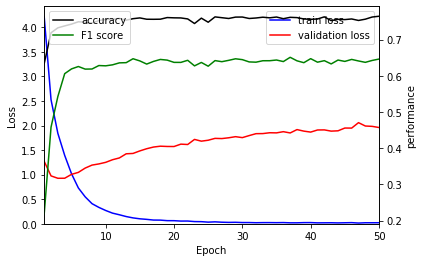

In [0]:
import matplotlib.pyplot as plt

epoch = np.arange(1,epochs+1)
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(epoch,train_losses,'b',label="train loss")
ax1.plot(epoch,validation_losses,'r',label="validation loss")
ax1.legend(loc=0)
ax1.set_ylabel('Loss')
ax1.set_xlabel("Epoch")
ax1.set_xlim(1,epochs)
ax1.set_ylim(0,None)
ax2 = ax1.twinx()
ax2.plot(epoch,accuracies,'k',label="accuracy")
ax2.plot(epoch,F1s,'g',label="F1 score")
ax2.legend(loc=2)
ax2.set_ylabel('performance')
# ax2.set_ylim(0.5,1)
plt.savefig("GUM.png",dpi=600)
plt.show()